In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils

%load_ext autoreload
%autoreload 2

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = ''
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'

In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [6]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)

In [7]:
def plot_fits(fitter, log_m_halo, test_error_type='percentile', 
              regularization_lambda=0.0, colors_test=None, colorbar_label=''):

    # Extract arrays and plot
    y_true = fitter.y_scalar_test
    y_pred = fitter.y_scalar_pred
    
    y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train,
                                  x_extra=fitter.x_features_extra_train)
    y_train_true = fitter.y_scalar_train
    
    log_m_halo_test = log_m_halo[fitter.idx_test]
    log_m_halo_train = log_m_halo[fitter.idx_train]

    # Compute error
    n_bins = 6
    err_bins_mstellar = np.linspace(min(y_true), max(y_true), n_bins+1)
    err_bins_mhalo = np.linspace(min(log_m_halo_test), max(log_m_halo_test), n_bins+1) # do only for test set
    idx_bins_mstellar = np.digitize(y_true, err_bins_mstellar)
    idx_bins_mhalo = np.digitize(log_m_halo_test, err_bins_mhalo)
    groups_mstellar = []
    groups_mhalo = []
    for i_err in range(n_bins):
        groups_mstellar.append( y_pred[idx_bins_mstellar==i_err-1] ) # -1 bc of how digitize returns results
        groups_mhalo.append( y_pred[idx_bins_mhalo==i_err-1] ) # -1 bc of how digitize returns results
        
    if test_error_type=='msfe':
        frac_err = (y_pred - y_true)/y_true
        msfe_test = np.mean(frac_err**2)
        error_str = f'MSFE: {msfe_test:.3f}'
        n_outliers = len(frac_err[frac_err > 5*msfe_test])
        # TODO: finish implementing binned errors
    elif test_error_type=='percentile':
        delta_y = y_pred - y_true
        percentile_16 = np.percentile(delta_y, 16, axis=0)
        percentile_84 = np.percentile(delta_y, 84, axis=0)
        error_inner68_test = (percentile_84-percentile_16)/2

        error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
        n_outliers = len(delta_y[delta_y > 5*error_inner68_test])
        
    
    train_text = ''
    if hasattr(fitter, 'chi2'):
        train_text = fr'$\chi^2$: {fitter.chi2:.3e}; $\kappa$: {fitter.condition_number:.1e}' '\n'

    #n_neg = len(np.where(fitter.y_scalar_pred < 0)[0])
    text_results = fr'$n_\mathrm{{features}}$: {fitter.n_A_features}' '\n' \
                       fr'{error_str} ($n_\mathrm{{test}}$: {fitter.n_test})' '\n' \
                       f'{train_text}' \
                       f'\t \t' fr'($n_\mathrm{{train}}$: {fitter.n_train})' '\n' \
                       fr'$N > 5\sigma$: {n_outliers}'

    
    y_true += log_mass_shift
    y_pred += log_mass_shift
    y_train_true += log_mass_shift
    y_train_pred += log_mass_shift
    
    plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                              text_results=text_results, 
                              colors_test=colors_test, colorbar_label=colorbar_label)

    log_m_halo_test += log_mass_shift
    log_m_halo_train += log_mass_shift
    plotter.plot_pred_vs_mass(log_m_halo_test, y_true, y_pred, log_m_halo_train, y_train_true, y_train_pred, 
                              text_results=text_results,
                              colors_test=colors_test, colorbar_label=colorbar_label)

In [8]:
uncertainty_floor = 8 # in log
uncertainties_01floor = np.sqrt((0.1*log_m_stellar)**2 + uncertainty_floor**2)

y_val_current_const = np.ones(len(log_m_stellar))

### Get x center info

In [9]:
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_com')

# first [0] is pos, second [0] is first particle
#pos_part0 = [halo.load_positions_and_velocities()[0][0] for halo in sim_reader.dark_halo_arr]
x_coms  = [halo.catalog_properties['x_com'] for halo in sim_reader.dark_halo_arr]
x_minPEs  = [halo.catalog_properties['x_minPE'] for halo in sim_reader.dark_halo_arr]

x_coms_shifted = np.array([sim_reader.dark_halo_arr[i].shift_points_torus(x_coms[i], x_minPEs[i]) for i in range(len(sim_reader.dark_halo_arr))])
x_minPEs_shifted = np.array([sim_reader.dark_halo_arr[i].shift_points_torus(x_minPEs[i], x_minPEs[i]) for i in range(len(sim_reader.dark_halo_arr))])

delta_x_norm = np.linalg.norm(x_coms_shifted - x_minPEs_shifted, axis=1)
#delta_x_norm = np.delete(delta_x_norm, idxs_nan_structure_catalog, axis=0)

sim_reader.add_catalog_property_to_halos('r200m')
r_200m = [halo.catalog_properties['r200m'] for halo in sim_reader.dark_halo_arr]
delta_x_norm_perr200m = delta_x_norm/r_200m

Text(0, 0.5, 'count')

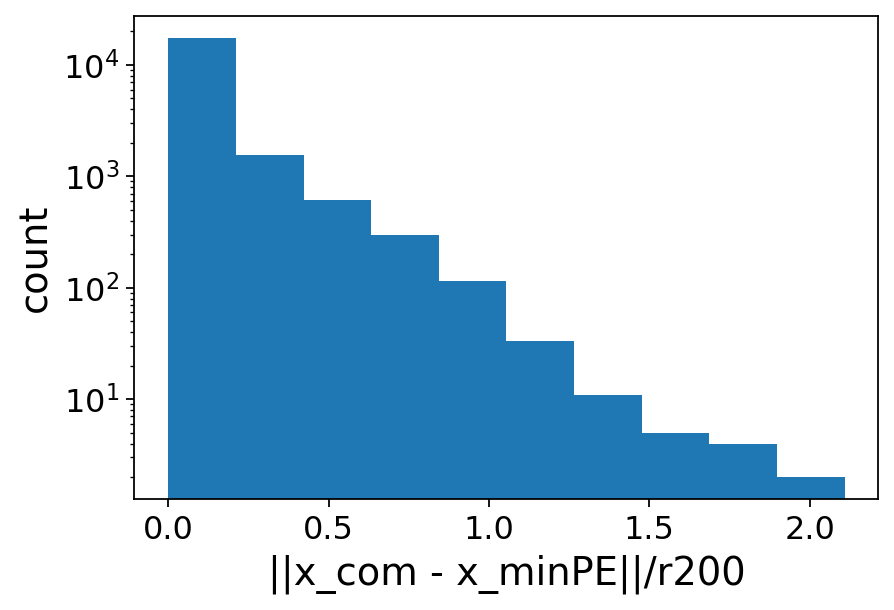

In [10]:
plt.hist(delta_x_norm_perr200m, log=True)
plt.xlabel('||x_com - x_minPE||/r200')
plt.ylabel('count')

Text(0, 0.5, 'count')

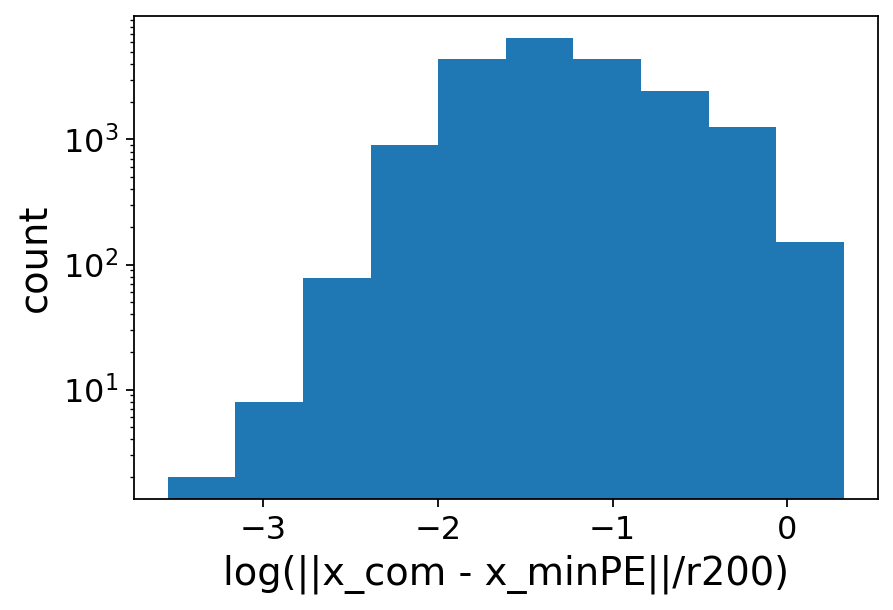

In [11]:
plt.hist(np.log10(delta_x_norm_perr200m), log=True)
plt.xlabel('log(||x_com - x_minPE||/r200)')
plt.ylabel('count')

### Two bins (inner/outer) eigenvalues, with rescaling

In [12]:
m_order_max = 2
n_groups_rebin = [[0,1,2], [3,4,5,6,7]]
eigenvalues_not_trace = True

In [13]:
scalar_featurizer_rescaled = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer_rescaled.compute_MXV_from_features()
scalar_featurizer_rescaled.rescale_geometric_features(scalar_featurizer_rescaled.M_tot, 
                                             scalar_featurizer_rescaled.X_rms, 
                                             scalar_featurizer_rescaled.V_rms)
scalar_featurizer_rescaled.featurize(m_order_max, n_groups_rebin=n_groups_rebin,
                        eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


In [14]:
# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer_rescaled.M_tot, 
                              scalar_featurizer_rescaled.X_rms,
                              scalar_featurizer_rescaled.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

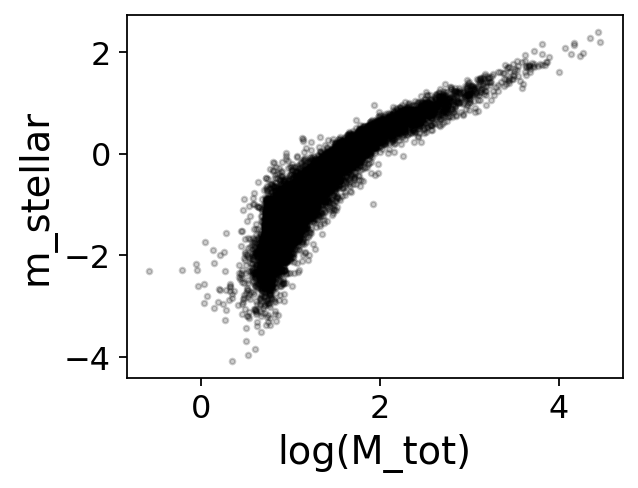

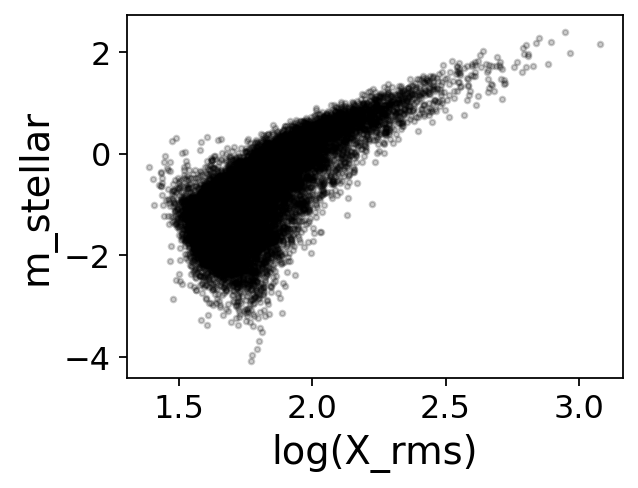

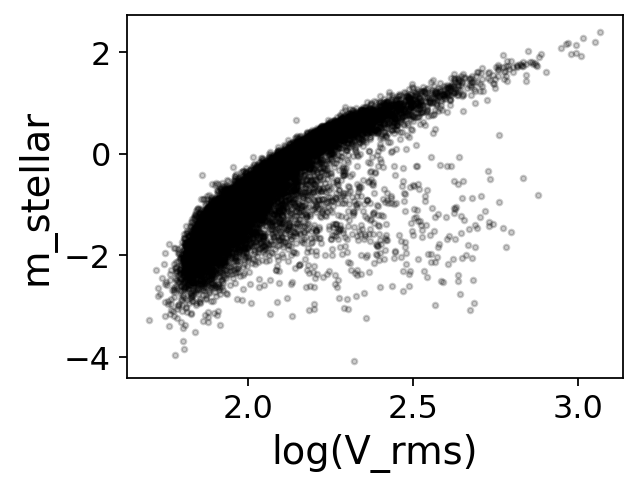

In [15]:
labels = ['log(M_tot)', 'log(X_rms)', 'log(V_rms)']
for i in range(x_features_extra.shape[1]):
    plt.figure(figsize=(4,3))
    plt.scatter(x_features_extra[:,i], log_m_stellar, s=6, alpha=0.2, c='k')
    plt.xlabel(labels[i])
    plt.ylabel('m_stellar')

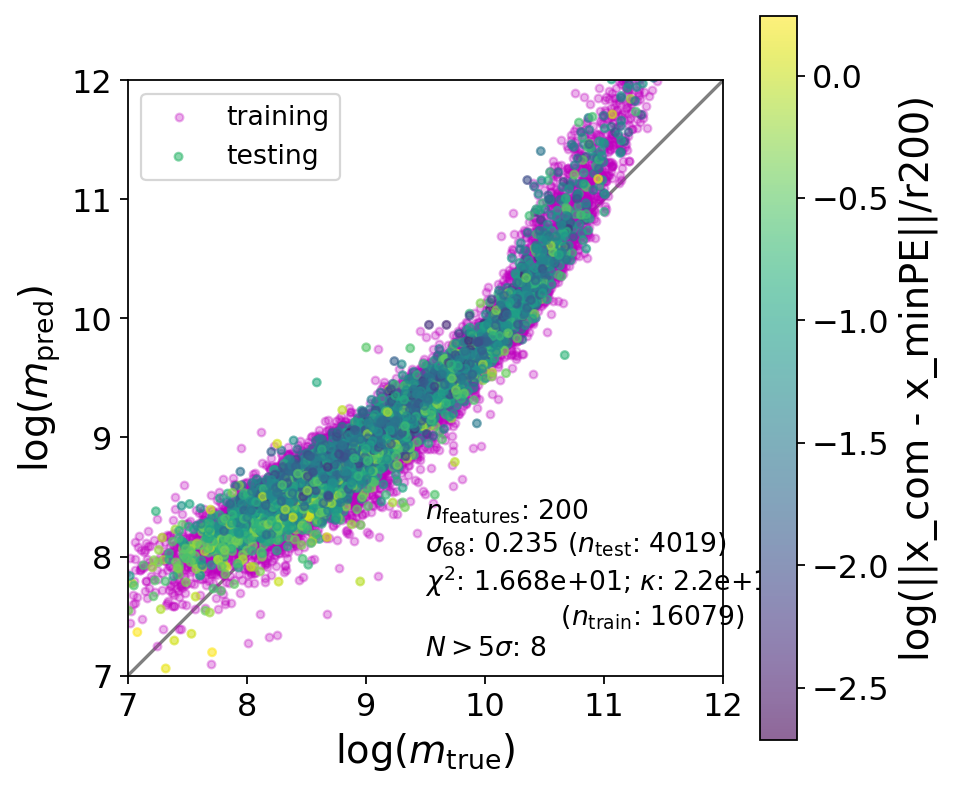

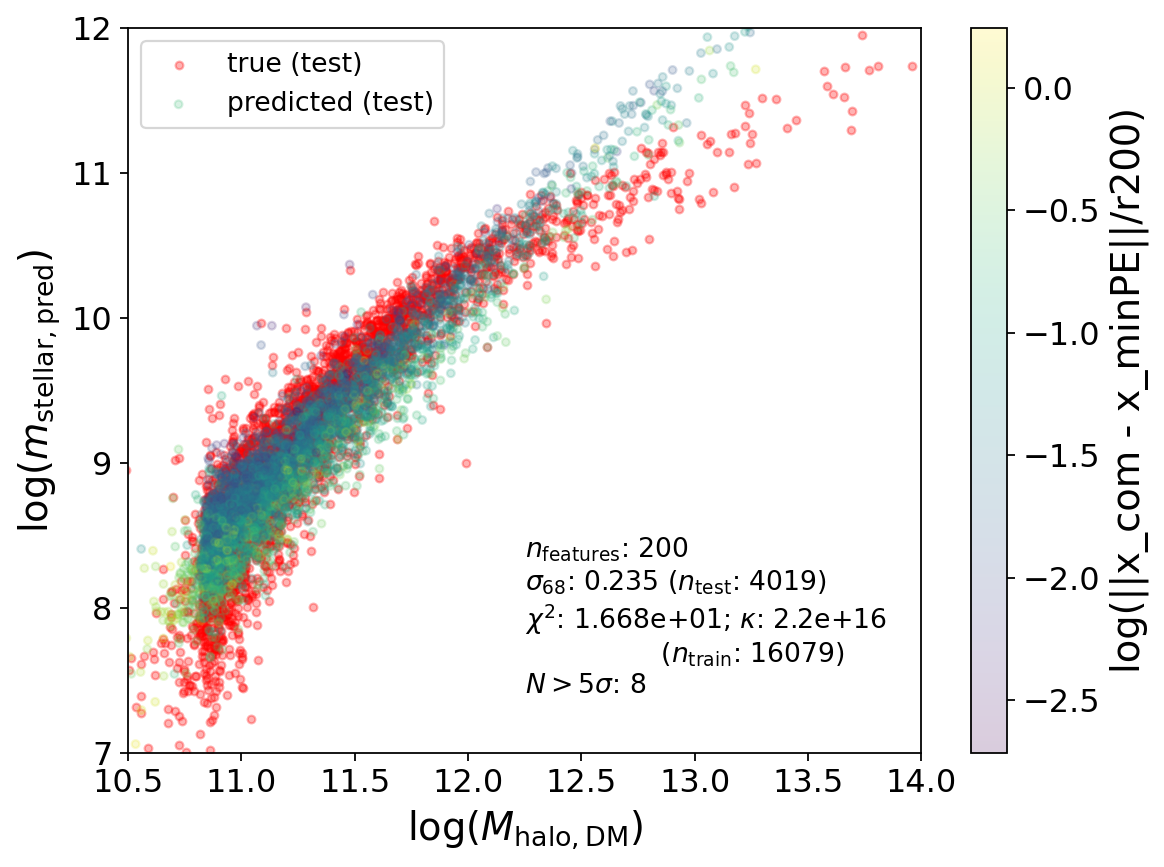

In [16]:
fitter = LinearFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                    y_val_current_const, uncertainties=uncertainties_01floor,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

### MXV + const ONLY

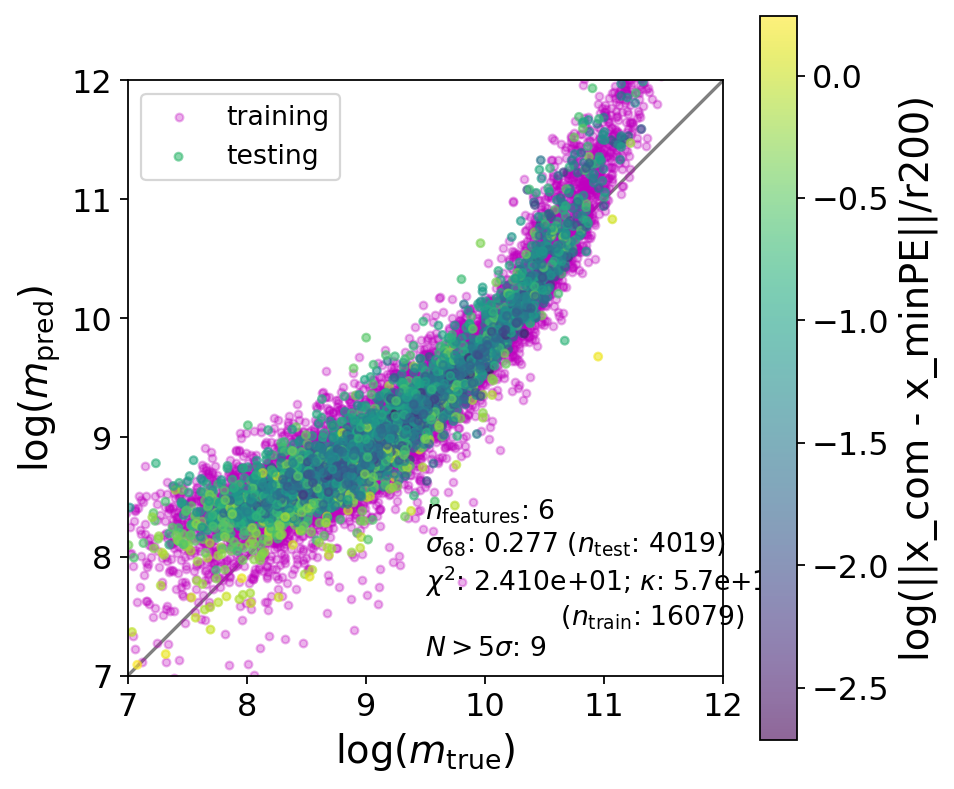

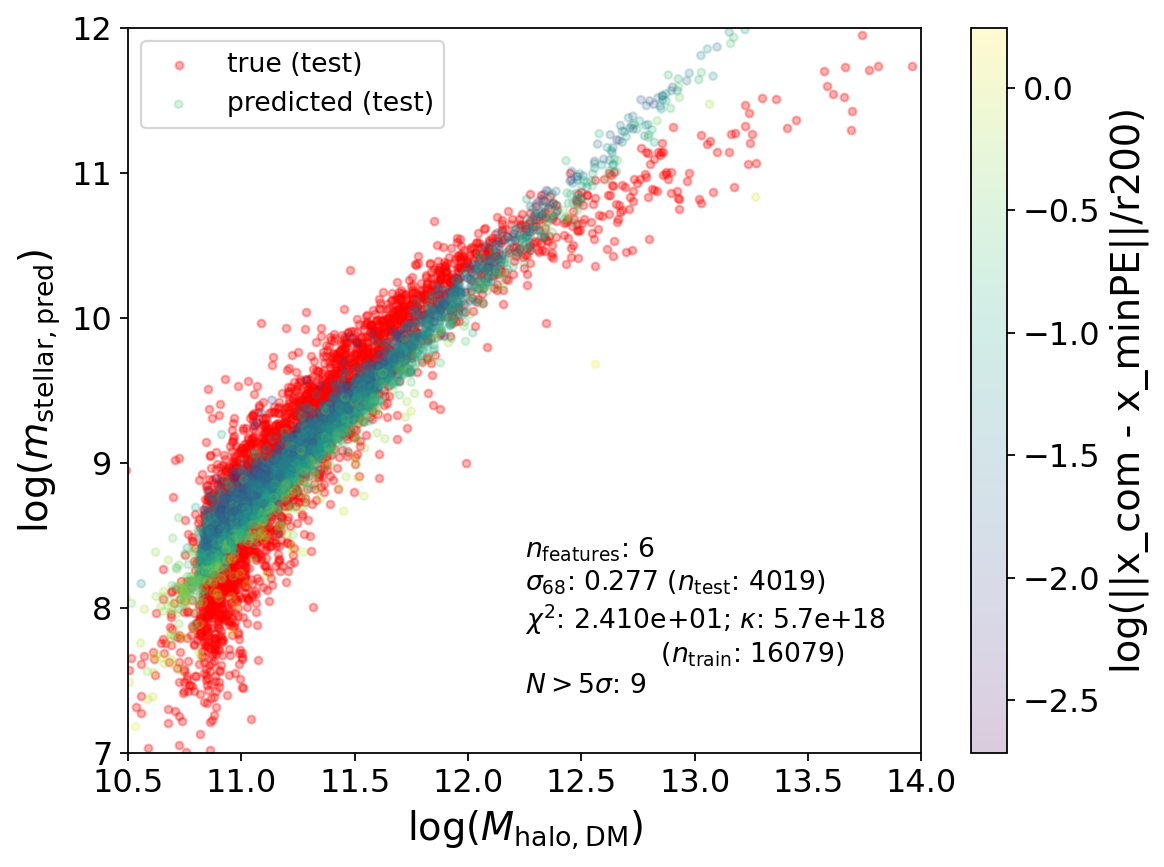

In [17]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_const, uncertainties=uncertainties_01floor,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Uncertainties

In [18]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

Text(0, 0.5, 'log($M_\\mathrm{stellar}$)')

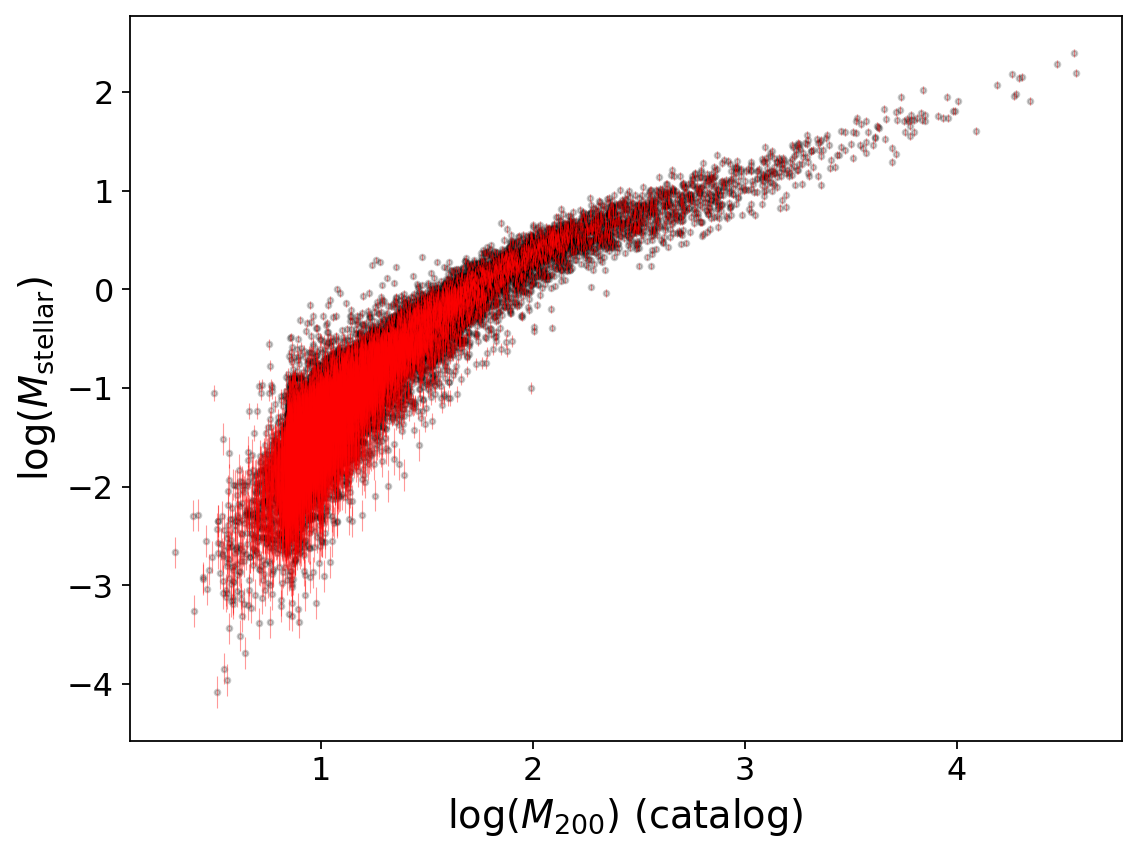

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(log_m_200m, log_m_stellar, color='k', s=6, alpha=0.2)
plt.errorbar(log_m_200m, log_m_stellar, yerr=uncertainties_genel2019, 
             color='red', lw=0, elinewidth=0.5, alpha=0.4)

plt.xlabel(r'log($M_\mathrm{200}$) (catalog)')
plt.ylabel(r'log($M_\mathrm{stellar}$)')

# Powerlaw

In [20]:
# maybe a better way to do this, but just logging for now to be consistent
def broken_power_law(log_M200, N=1, log_M1=12-log_mass_shift, beta=1, gamma=1):
    return log_M200 + np.log10( 2*N/((log_M200/log_M1)**(-beta) + (log_M200/log_M1)**gamma) )

In [21]:
M1 = 12-log_mass_shift
p0 = [0.01, M1, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, log_m_200m, log_m_stellar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(log_m_200m, *popt)

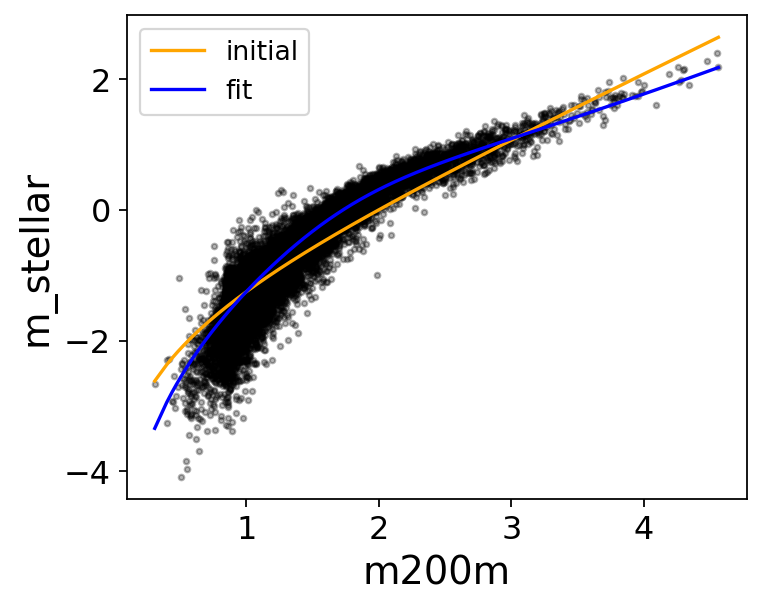

In [22]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m)
y_initial = broken_power_law(log_m_200m, *p0)
plt.scatter(log_m_200m[idx_m_200m], log_m_stellar[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m[idx_m_200m], y_initial[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m[idx_m_200m], y_val_current_powerlaw_fit[idx_m_200m], color='blue', label='fit')
plt.xlabel('m200m')
plt.ylabel('m_stellar')
plt.legend(fontsize=12)

### MXV + powerlaw + const

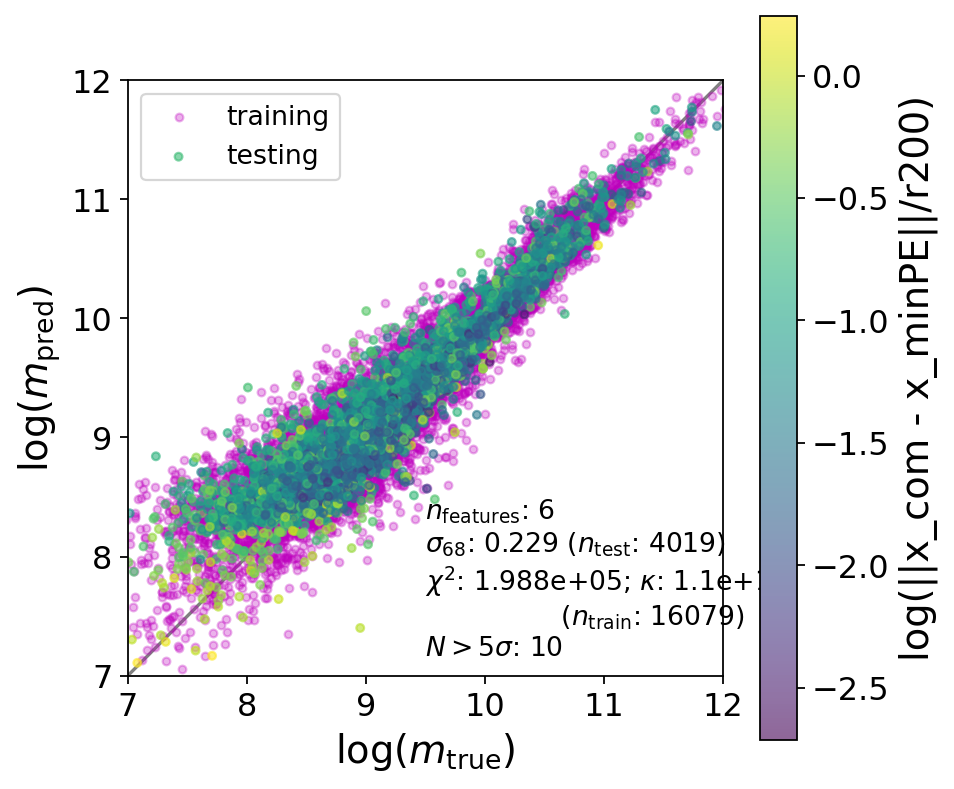

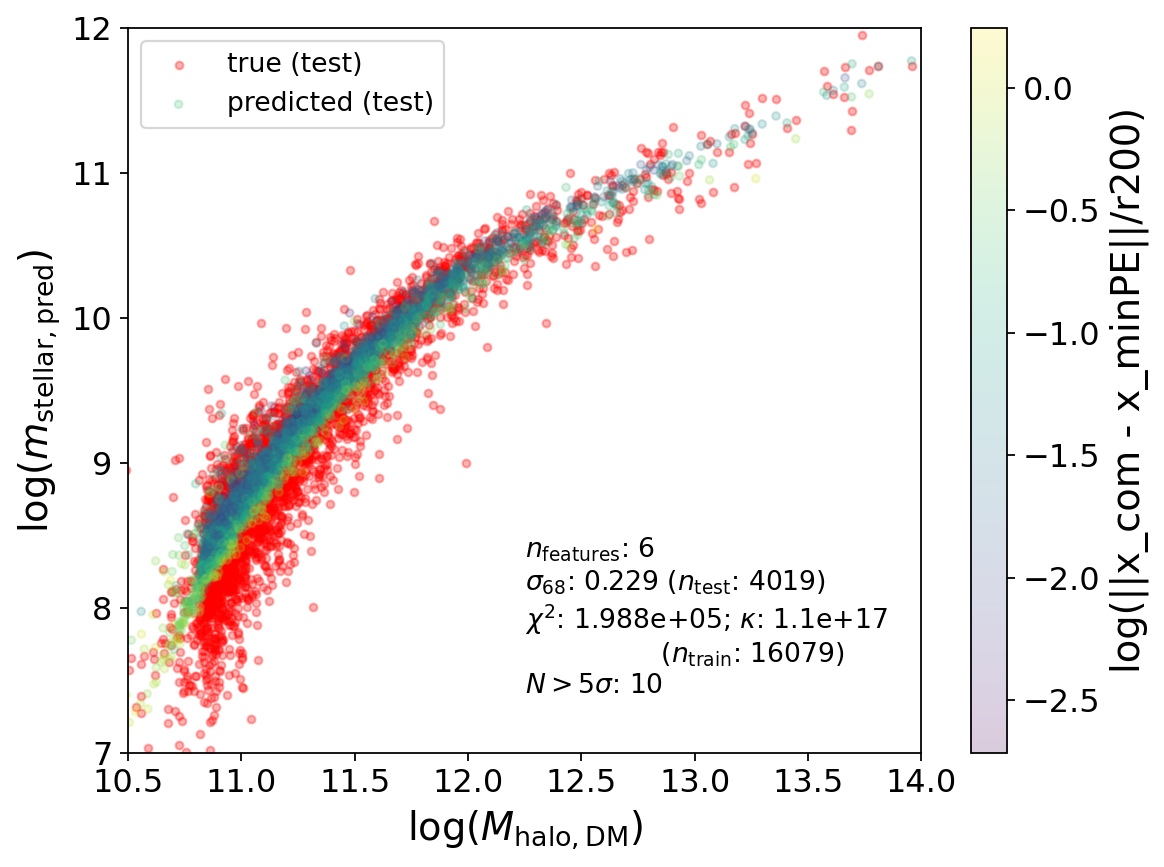

In [23]:
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

### 2 bins, rescaling, MXV + powerlaw + const

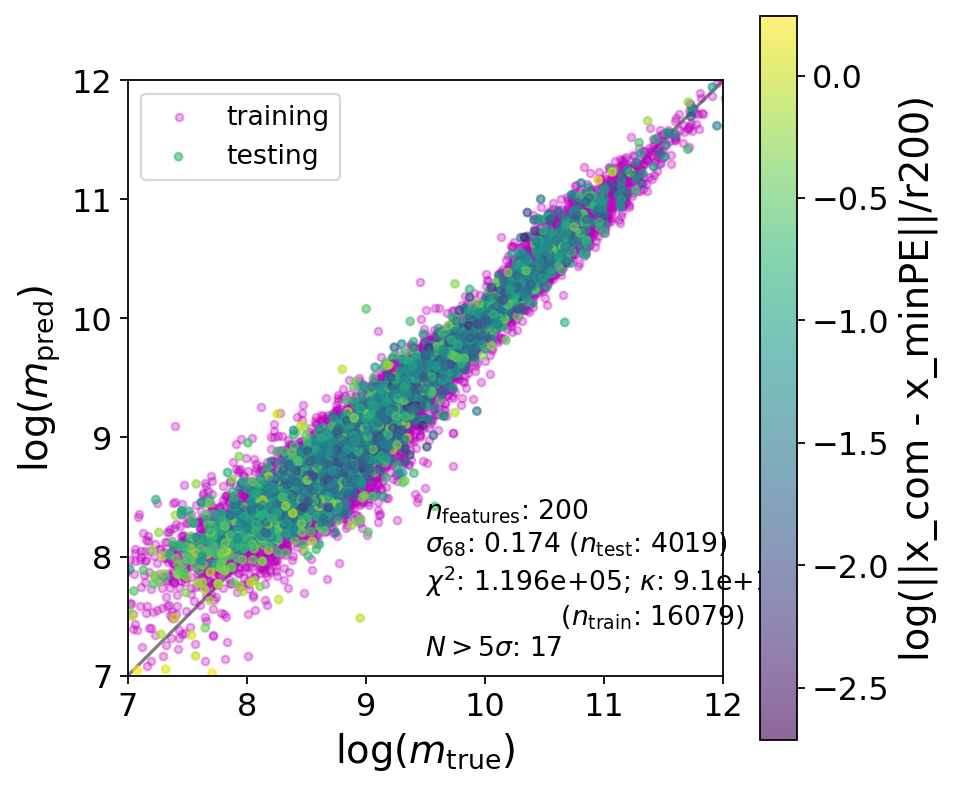

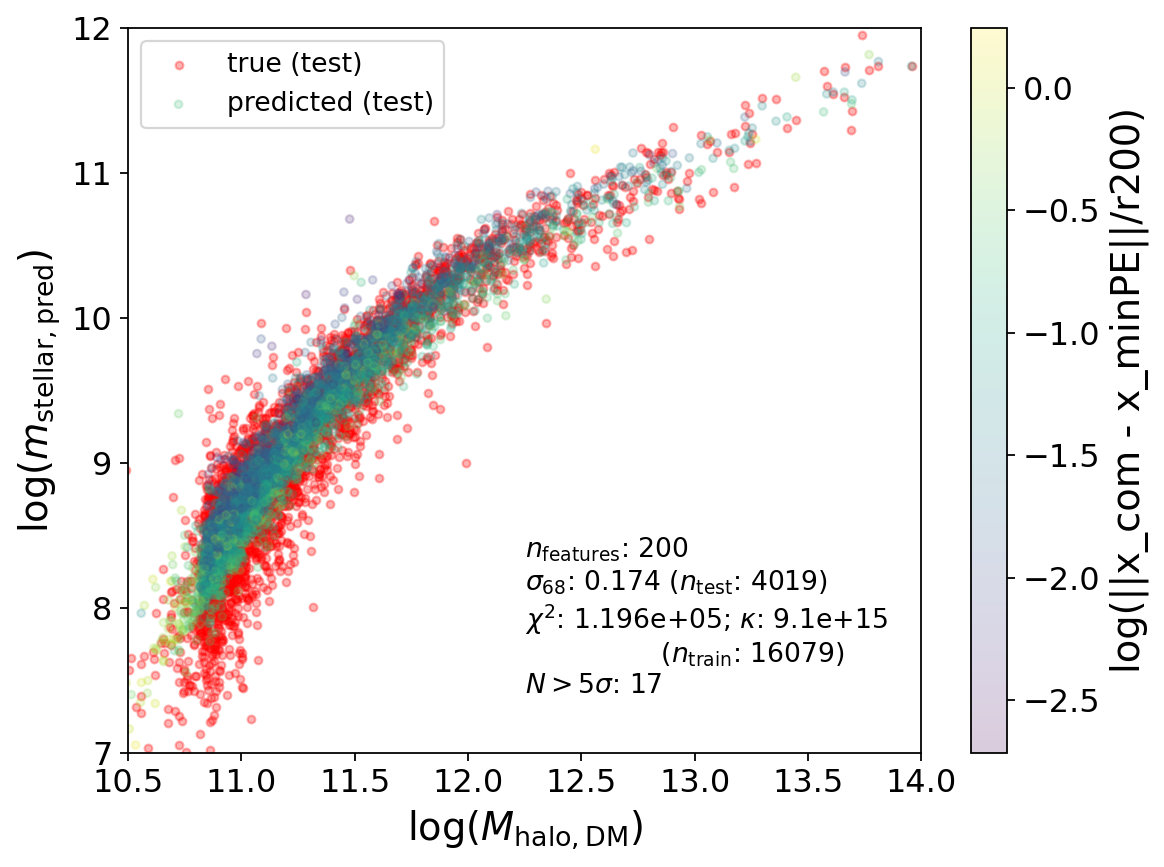

In [24]:
fitter = LinearFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Regularization

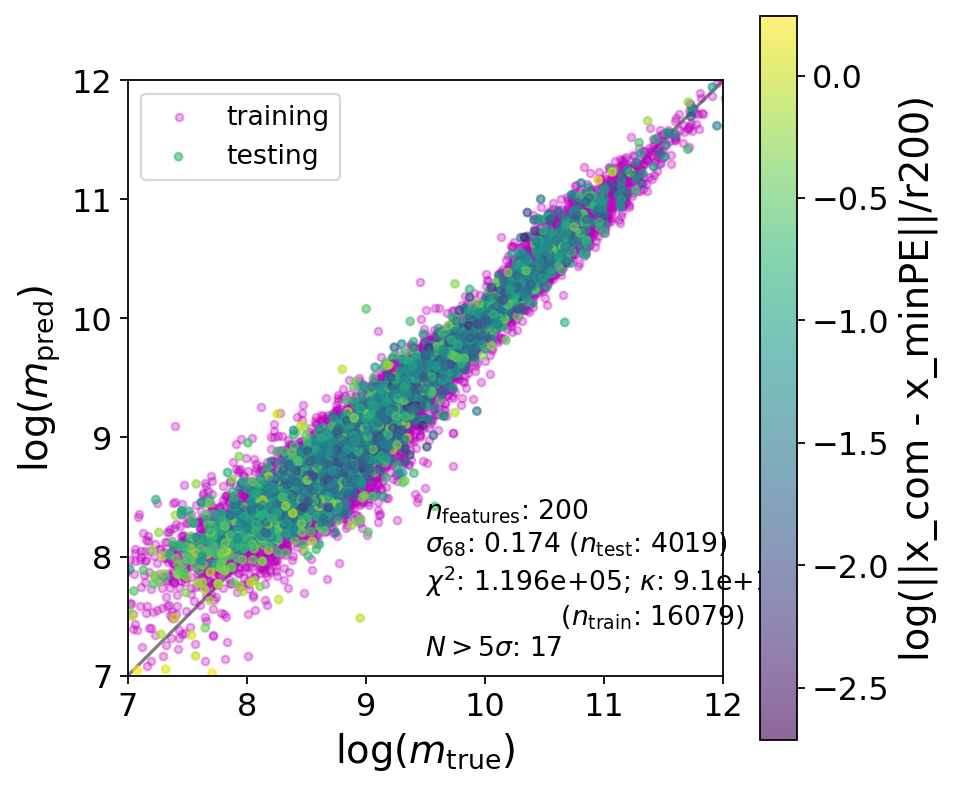

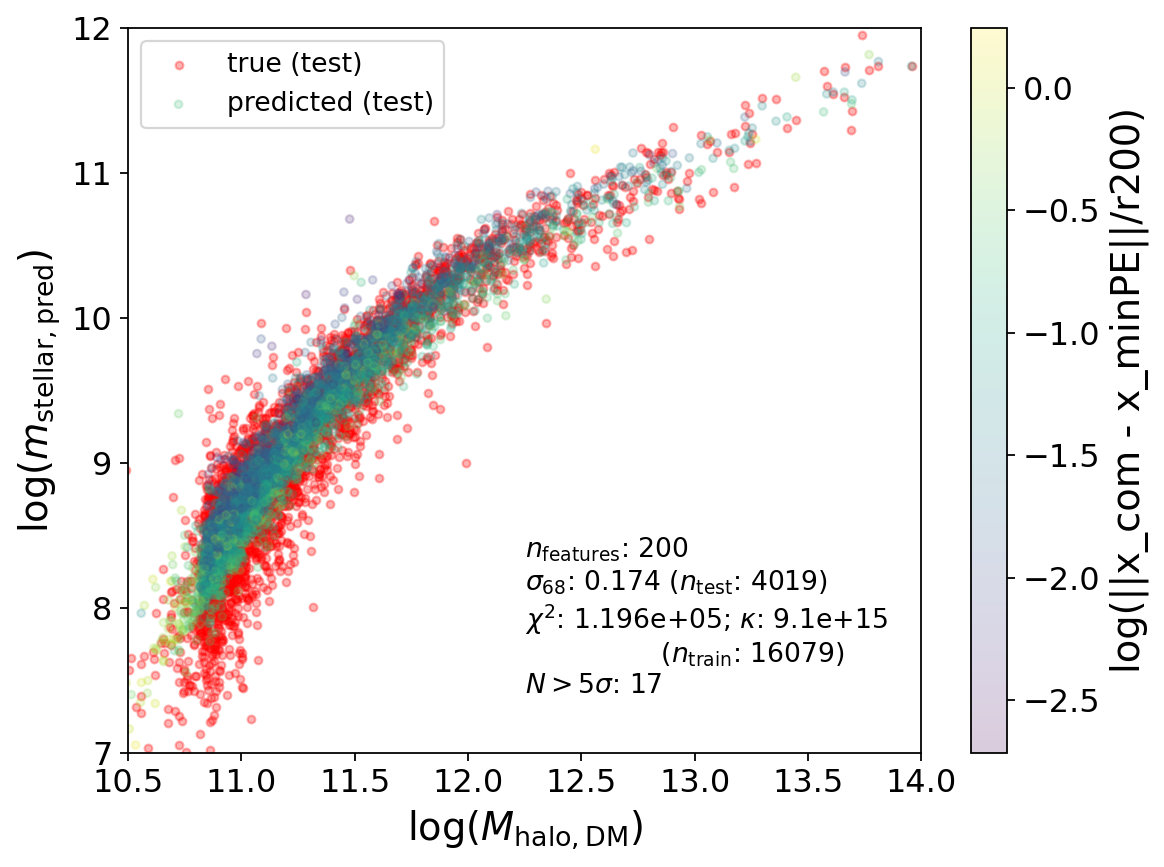

In [25]:
fitter = LinearFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Neural net

In [26]:
nnfitter = NNFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                y_val_current_powerlaw_fit, x_features_extra=x_features_extra)
nnfitter.split_train_test()
nnfitter.set_up_data()

In [27]:
input_size = nnfitter.n_A_features
hidden_size = 32
nnfitter.model = NeuralNet(input_size, hidden_size=hidden_size)
nnfitter.train()

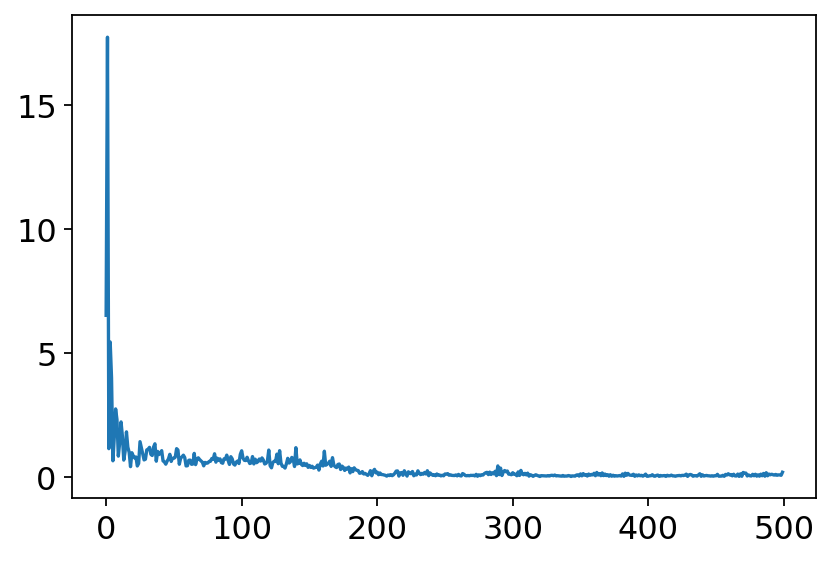

In [28]:
plt.plot(nnfitter.loss)

In [29]:
nnfitter.predict_test()

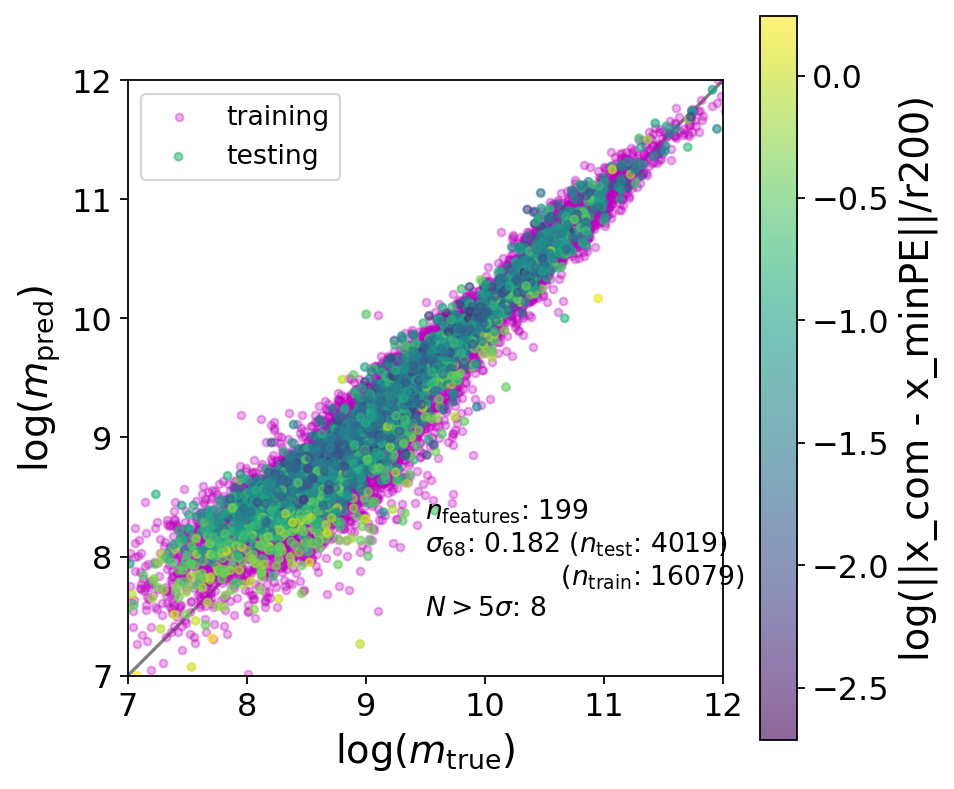

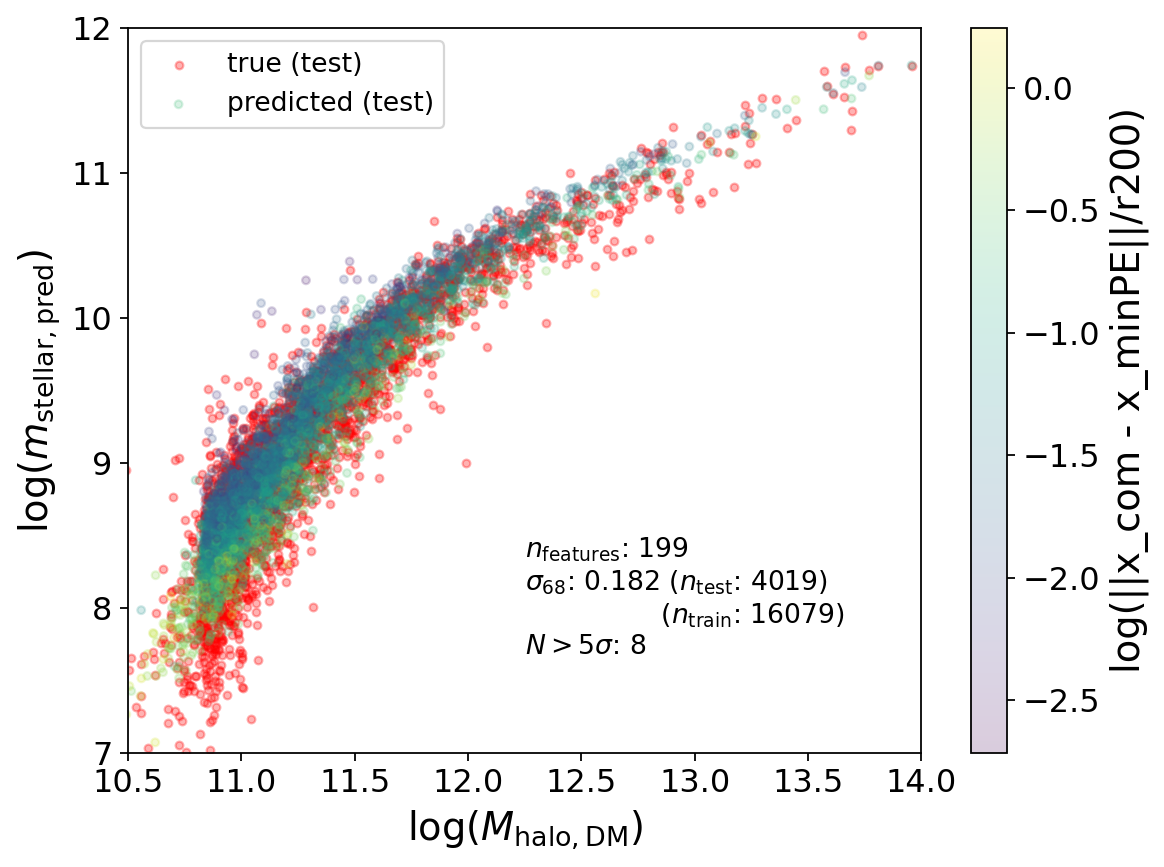

In [30]:
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plot_fits(nnfitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')